<a href="https://colab.research.google.com/github/sdlm/test_cases/blob/main/cian_test_draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from typing import List

import itertools
from operator import itemgetter
import json
from multiprocessing import Pool

import numpy as np
import pandas as pd
import seaborn as sns

from tqdm.notebook import tqdm, trange
import plotly.express as px
try:
    px.set_mapbox_access_token(open("./data/.mapbox_token").read())
except:
    pass
    
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from scipy import stats
from scipy.stats import gaussian_kde
from scipy.special import expit

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import linear_model 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
sns.axes_style("white")
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set(font_scale=1.3)

np.random.seed(42)

%matplotlib inline

In [ ]:
df = pd.read_csv('./data/cian_test_task.csv', sep=';')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22756 entries, 0 to 22755
Data columns (total 56 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   cianid                        22756 non-null  int64  
 1   category                      22756 non-null  object 
 2   taxnumber                     485 non-null    object 
 3   waterpipescount               1383 non-null   object 
 4   islegaladdressprovided        2850 non-null   object 
 5   floormaterialtype             106 non-null    object 
 6   hasshopwindows                1172 non-null   object 
 7   floornumber                   22756 non-null  int64  
 8   accesstype                    6631 non-null   object 
 9   conditiontype                 13784 non-null  object 
 10  canparts                      20587 non-null  object 
 11  userid                        22756 non-null  int64  
 12  bargainterms                  22756 non-null  object 
 13  p

In [ ]:
# Удалим фичи которые кажутся очевидно не существенными
df.drop(columns=['cianid', 'userid', 'manageruserid'], axis=1, inplace=True)

In [ ]:
# Удалим фичи которые не имеют ни одной записи
non_values_feats = [
    'drivewaytype',
    'conditionratingtype',
    'gaspressure',
    'drainagecapacity',
    'electricitypower'
]
df.drop(columns=non_values_feats, axis=1, inplace=True)

In [ ]:
# Пока не будем рассматривать координаты обьектов
geo_coordinates_feats = ['geo_coordinates_lat', 'geo_coordinates_lng']
df.drop(columns=geo_coordinates_feats, axis=1, inplace=True)

In [ ]:
for f in [
    'price_per_year_per_m2', 
    'totalarea', 
    'bargainterms_price', 
    'bargainterms_minleaseterm',
    'bargainterms_securitydeposit',
    'bargainterms_vatprice'
]:
    df[f] = pd.to_numeric(
        df[f].str.replace(',', '.'), 
        errors='raise'
    )
    
df['ptn_dadd'] = pd.to_datetime(df['ptn_dadd'], errors='raise').dt.date

df.rename(columns={"price_per_year_per_m2": "target"}, inplace=True)

Честно говоря, совсем не сразу, но я обнаружил такой лик в данных. Что такое `price_per_year_per_m2` это по сути цена за год поделённая на площадь обьекта. Но .. на какие сроки обычно заключают догововы в long-term аренде ? Честно говоря незнаю как там в корп. недвижимости, но при сдаче жилья типовой контракт подписывается на год. Предположим что это выполняется и для большей части корп. недвижимости. Тогда `price_per_year_per_m2` - есть не что иное как цена контракта разделённая на площадь обьекта. Проверим!

In [ ]:
df['target_pred'] = df.apply(lambda x: x['bargainterms_price'] / x['totalarea'], axis=1)
df[['target', 'target_pred']].corr()

target  target_pred
target       1.000000     0.998719
target_pred  0.998719     1.000000

Действительно, корреляция 99%. 

Формально мы нашли идеальное рещение поставленной задачи. Эвристика, которая позволяет нам найти ответ с высокой точностью вообще без использования методов анализа данных.

Но я понимаю что это просто пропущенный лик в данных. Исключим все фичи связанные с договором `bargainterms%`. Потому что, вероятно, нам нужно будет оценивать стоимость обьекта **до** факта заключения договора.

In [ ]:
df.drop(columns=['target_pred'], axis=1, inplace=True)

In [ ]:
future_feats = [
    'bargainterms',
    'bargainterms_price',
    'bargainterms_currency',
    'bargainterms_agentfee',
    'bargainterms_prepaymonths',
    'bargainterms_paymentperiod',
    'bargainterms_hasgraceperiod',
    'bargainterms_minleaseterm',
    'bargainterms_securitydeposit',
    'bargainterms_vatincluded',
    'bargainterms_vattype',
    'bargainterms_vatprice',
    'bargainterms_pricetype',
    'bargainterms_includedoptions',
]
df.drop(columns=future_feats, axis=1, inplace=True)

In [ ]:
def read_data() -> pd.DataFrame:
    df = pd.read_csv('./data/cian_test_task.csv', sep=';')

    # Удалим фичи которые кажутся очевидно не существенными
    df.drop(columns=['cianid', 'userid', 'manageruserid'], axis=1, inplace=True)

    # Пока не будем рассматривать координаты обьектов
#     geo_coordinates_feats = ['geo_coordinates_lat', 'geo_coordinates_lng']
#     df.drop(columns=geo_coordinates_feats, axis=1, inplace=True)

    future_feats = [
        'bargainterms',
        'bargainterms_price',
        'bargainterms_currency',
        'bargainterms_agentfee',
        'bargainterms_prepaymonths',
        'bargainterms_paymentperiod',
        'bargainterms_hasgraceperiod',
        'bargainterms_minleaseterm',
        'bargainterms_securitydeposit',
        'bargainterms_vatincluded',
        'bargainterms_vattype',
        'bargainterms_vatprice',
        'bargainterms_pricetype',
        'bargainterms_includedoptions',
    ]
    df.drop(columns=future_feats, axis=1, inplace=True)

    for f in [
        'price_per_year_per_m2', 
        'totalarea',
    ]:
        df[f] = pd.to_numeric(
            df[f].str.replace(',', '.'), 
            errors='raise'
        )

    df['ptn_dadd'] = pd.to_datetime(df['ptn_dadd'], errors='raise').dt.date

    df.rename(columns={"price_per_year_per_m2": "target"}, inplace=True)

    return df

In [ ]:
def add_new_feats(df: pd.DataFrame) -> pd.DataFrame:
    df['building.floorsCount'] = df['building'].apply(json.loads)\
    .apply(pd.Series)['floorsCount']

    df['geo_district_mod'] = df['geo_district'].str.replace('true', '1')\
    .str.replace('false', '0')\
    .str.replace('\'', '')

    df['geo_district.raion'] = df['geo_district_mod'].apply(
        lambda x: ','.join([e['name'] for e in json.loads(x) if e['type'] == 'raion'])
    )
    df['geo_district.mikroraion'] = df['geo_district_mod'].apply(
        lambda x: ','.join([e['name'] for e in json.loads(x) if e['type'] == 'mikroraion'])
    )
    df['geo_district.okrug'] = df['geo_district_mod'].apply(
        lambda x: ','.join([e['name'] for e in json.loads(x) if e['type'] == 'okrug'])
    )

    df['building.floorsCount_dec'] = df['building.floorsCount'].apply(lambda x: x//10)
    
    return df

# численные фичи

In [ ]:
# выделим численные фичи
col_groups = df.columns.to_series().groupby(df.dtypes).groups
real_num_feats = list(col_groups[np.dtype('float64')]) + list(col_groups[np.dtype('int64')])

In [ ]:
real_num_feats

['target', 'totalarea', 'floornumber']

In [ ]:
df[real_num_feats].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22756 entries, 0 to 22755
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   target       22756 non-null  float64
 1   totalarea    22756 non-null  float64
 2   floornumber  22756 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 533.5 KB


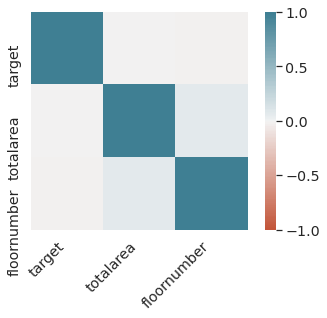

In [ ]:
# посмотрим на корреляции численных фичей
corr = df[real_num_feats].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

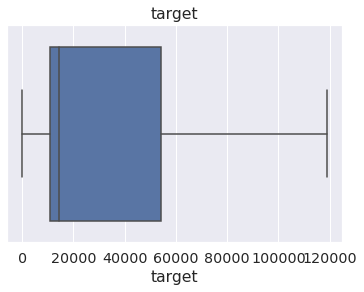

In [ ]:
# посмотрим на интерквантильный размах что бы отсечь выбросы
sns.boxplot(x=df['target'], showfliers=False).set(title='target');

In [ ]:
# def drop_upper_fliers(df, feat):
#     q1, q3 = df[feat].quantile([.25, .75])
#     result = df[df[feat] < q3 + 1.5 * (q3 - q1)]
#     print(f'drop {(df.shape[0] - result.shape[0]) / df.shape[0] * 100:.1f}% rows')
#     return result

# df = drop_upper_fliers(df, 'target')

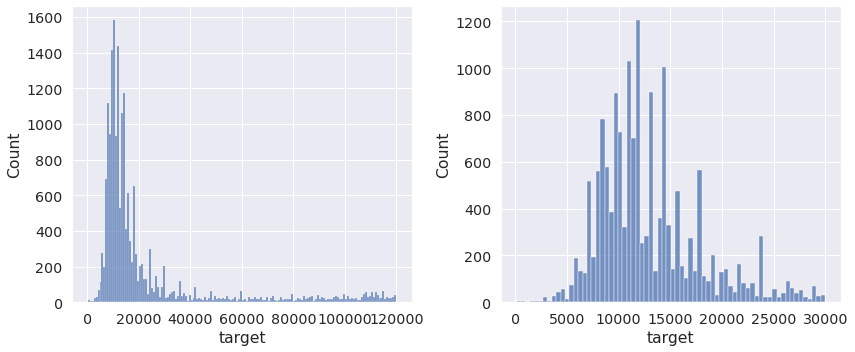

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(12,5))
sns.histplot(data=df[df['target'] < 120000], x="target", ax=axs[0]);
sns.histplot(data=df[df['target'] < 30000], x="target", ax=axs[1]);
fig.tight_layout()

In [ ]:
f'{df[df.target < 30000].shape[0] / df.shape[0] * 100:.1f}% rows'

'69.5% rows'

Можно видеть что значения целевой величины сосредоточены вокруг значения ~15k и распределение имеет очень длинный и тяжёлый правый конец. Даже отсечение выбросов по правилу 1.5 интерквантильного размаха не помогает.

В данном случае считаю наиболее правильным рассмотреть обьекты с ценовым диапазоном до 30k 
отдельно. В сегменте "до 30k" распределение похоже на нормальное, и этот сегмент составляет ~70% от генеральной совокупности (т.е. по почти по правилу Паретто).

После того как для сегмента "до 30k" будут получены удовлетворяющие результаты и останется время для дальнейших исследований, можно будет подробнее рассмотреть сегмент "более 30k".

# Рассмотрим детальнее сегмент "до 30k"

In [ ]:
df = df[df.target < 30000]

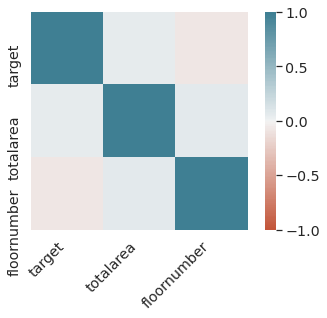

In [ ]:
# посмотрим на корреляции численных фичей
corr = df[real_num_feats].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

В качестве бейзлайна было предложено выбрать среднее значение цены по всей совокупности, т.о. наш бейзлайн это:

In [ ]:
metrics.r2_score(
    y_true=df.target, 
    y_pred=np.full((df.shape[0],), df.target.mean())
)

0.0

Мы уже могли видеть корреляцию между целевым значением и фичами `bargainterms_price`, `bargainterms_securitydeposit`, так что в качестве первого приближения можно построить линейную регрессию по этим двум фичам.

In [ ]:
def print_metrics_raw(y_true, y_pred, label = 'test'):
    r2 = metrics.r2_score(y_true=y_true, y_pred=y_pred)
    mse = metrics.mean_squared_error(y_true=y_true, y_pred=y_pred)
    mape = metrics.mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred)

    print(f"      {label:>20}")
    print(f'R2    {r2:>20.3f}')
    print(f'MSE   {mse:>20.2f}')
    print(f'MAPE  {mape:>20.3f}')

def print_metrics(X_train, X_test, y_train, y_test, model):
    r2_train = metrics.r2_score(y_true=y_train, y_pred=model.predict(X_train))
    r2_test = metrics.r2_score(y_true=y_test, y_pred=model.predict(X_test))

    mse_train = metrics.mean_squared_error(y_true=y_train, y_pred=model.predict(X_train))
    mse_test = metrics.mean_squared_error(y_true=y_test, y_pred=model.predict(X_test))

    mape_train = metrics.mean_absolute_percentage_error(
        y_true=y_train, y_pred=model.predict(X_train)
    )
    mape_test = metrics.mean_absolute_percentage_error(
        y_true=y_test, y_pred=model.predict(X_test)
    )

    print(f"    {'train':>20}  {'test':>20}")
    print(f'R2  {r2_train:>20.3f}  {r2_test:>20.3f}')
    print(f'MSE {mse_train:>20.2f}  {mse_test:>20.2f}')
    print(f'MAPE{mape_train:>20.3f}  {mape_test:>20.3f}')

In [ ]:
numeric_feats = list(set(real_num_feats) - set(['target']))
X = df[numeric_feats].values
y = df.target.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# незаполненные значения заменим на среднее
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train = imp.fit_transform(X_train)
X_test = imp.transform(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

reg = linear_model.LinearRegression().fit(X_train, y_train)

print_metrics(X_train, X_test, y_train, y_test, model=reg)

                   train                  test
R2                 0.009                 0.006
MSE          24747401.27           23218644.16
MAPE               0.378                 0.339


In [ ]:
reg.coef_

array([ 324.65397882, -383.81484234])

Результаты не впечатляющие, всего 0.6% обьяснённой дисперсии на тесте. Более того, большие коэфициенты указывают на переобучение.

In [ ]:
numeric_feats = list(set(real_num_feats) - set(['target']))
X = df[numeric_feats].values
y = df.target.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# незаполненные значения заменим на среднее
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train = imp.fit_transform(X_train)
X_test = imp.transform(X_test)

forest = RandomForestRegressor(random_state=42).fit(X_train, y_train)

print_metrics(X_train, X_test, y_train, y_test, model=forest)

                   train                  test
R2                 0.595                 0.281
MSE          10127989.32           16803497.17
MAPE               0.200                 0.259


Случайный лес на тех же данных позволяет обьяснить 28% дисперсии на тесте.

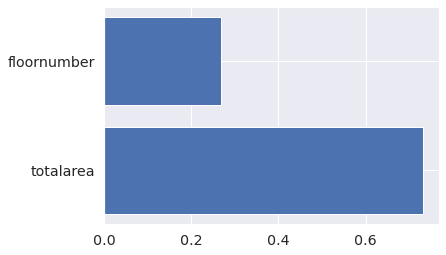

In [ ]:
plt.barh(numeric_feats, forest.feature_importances_.squeeze());

# выделим категориальные фичи

In [ ]:
col_groups = df.columns.to_series().groupby(df.dtypes).groups
cat_feats = list(col_groups[np.dtype('object')])

In [ ]:
df[cat_feats].nunique().sort_values(ascending=False)

geo                       8517
building                  4231
geo_userinput             4153
geo_address               2978
businessshoppingcenter     866
minarea                    436
specialty                  255
land                       216
geo_district               133
electricity                 78
taxnumber                   26
conditiontype                6
waterpipescount              5
status                       5
inputtype                    4
category                     4
layout                       4
ptn_dadd                     4
placementtype                2
isoccupied                   2
canparts                     2
hasfurniture                 2
accesstype                   2
hasshopwindows               2
floormaterialtype            2
islegaladdressprovided       2
gas                          1
water                        1
drainage                     1
dtype: int64

In [ ]:
feats_with_small_uniq_vals = [
    'hasshopwindows',
    'islegaladdressprovided',
    'floormaterialtype',
    'placementtype',
    'hasfurniture',
    'accesstype',
    'canparts',
    'isoccupied',
]
for feat in feats_with_small_uniq_vals:
    print(f'{feat:>30}, {df[feat].unique()}')

                hasshopwindows, [True nan False]
        islegaladdressprovided, [nan True False]
             floormaterialtype, [nan 'concrete' 'polymeric']
                 placementtype, ['shoppingMall' nan 'streetRetail']
                  hasfurniture, [False nan True]
                    accesstype, [nan 'free' 'passSystem']
                      canparts, [False True nan]
                    isoccupied, [nan True False]


In [ ]:
df[feats_with_small_uniq_vals].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15826 entries, 1 to 22755
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   hasshopwindows          681 non-null    object
 1   islegaladdressprovided  2636 non-null   object
 2   floormaterialtype       102 non-null    object
 3   placementtype           1242 non-null   object
 4   hasfurniture            2500 non-null   object
 5   accesstype              6282 non-null   object
 6   canparts                14227 non-null  object
 7   isoccupied              2642 non-null   object
dtypes: object(8)
memory usage: 1.1+ MB


In [ ]:
df[['drainage', 'water', 'gas']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15826 entries, 1 to 22755
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   drainage  15826 non-null  object
 1   water     15826 non-null  object
 2   gas       15826 non-null  object
dtypes: object(3)
memory usage: 494.6+ KB


фичи 'drainage', 'water', 'gas' абсолютно бесполезны

In [ ]:
feats_with_big_uniq_vals = [
    'minarea',
    'specialty',
    'land',
    'geo_district',
    'electricity',
    'taxnumber',
]
for feat in feats_with_big_uniq_vals:
    print(df.groupby(feat)[feat].count().sort_values(ascending=False).head(10))

minarea
100,0    315
50,0      78
30,0      43
20,0      38
70,0      29
25,0      27
40,0      27
80,0      26
500,0     26
200,0     24
Name: minarea, dtype: int64
specialty
{"additionalTypes":[],"types":[]}                                                                                                       15067
{"additionalTypes":[],"types":["streetRetail"]}                                                                                           328
{"additionalTypes":[],"types":["flexiblePurpose"]}                                                                                         14
{"additionalTypes":[],"types":["shop"]}                                                                                                    14
{"additionalTypes":[],"types":["shoppingFloorSpace"]}                                                                                      14
{"additionalTypes":["любое"],"types":[]}                                                                          

In [ ]:
df[feats_with_big_uniq_vals].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15826 entries, 1 to 22755
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   minarea       1956 non-null   object
 1   specialty     15826 non-null  object
 2   land          15826 non-null  object
 3   geo_district  15826 non-null  object
 4   electricity   15826 non-null  object
 5   taxnumber     462 non-null    object
dtypes: object(6)
memory usage: 865.5+ KB


Из категориальных фичей с большим кол-вом уникальных значений представляет интерес разве что фича `geo_district` из которой можно извлечь название района. 

Все остальные фичи несут слишком мало информации. Например `bargainterms_agentfee` для 14k записей (из 15k) заполнено нулём, а для фичи `minarea` определено всего лишь 2k значений.

In [ ]:
feats_with_huge_uniq_vals = [
    'geo',
    'building',
    'geo_userinput',
    'geo_address',
    'businessshoppingcenter',
]
for feat in feats_with_huge_uniq_vals:
    print(df.groupby(feat)[feat].count().sort_values(ascending=False).head(10))

geo
{"countryId":138,"undergrounds":[{"transportType":"walk","name":"Спортивная","lineColor":"700579","time":9,"lineId":17,"id":219,"isDefault":true},{"transportType":"walk","name":"Чкаловская","lineColor":"700579","time":13,"lineId":17,"id":218},{"transportType":"walk","name":"Василеостровская","lineColor":"069857","time":22,"lineId":15,"id":205}],"calculatedUndergrounds":[{"transportType":"walk","time":22,"distance":1879,"id":205},{"transportType":"transport","time":3,"distance":1979,"id":205},{"transportType":"walk","time":7,"distance":608,"id":219},{"transportType":"transport","time":1,"distance":645,"id":219},{"transportType":"walk","time":14,"distance":1186,"id":218},{"transportType":"transport","time":1,"distance":1137,"id":218}],"coordinates":{"lat":59.954047,"lng":30.28961},"highways":[],"railways":[{"id":226,"directionIds":[5],"distance":5.0,"time":65,"name":"Санкт-Петербург (Витебский вокзал)","travelType":"byFoot"},{"id":231,"directionIds":[10],"distance":5.0,"time":65,"nam

geo_address
['{"name":"Санкт-Петербург","id":2,"locationTypeId":1,"fullName":"Санкт-Петербург","type":"location","shortName":"Санкт-Петербург","isFormingAddress":true}', '{"name":"Лесной","id":4183,"fullName":"Лесной проспект","type":"street","shortName":"Лесной просп.","isFormingAddress":true}', '{"name":"64","id":1131415,"fullName":"64","type":"house","shortName":"64","isFormingAddress":true}']                                                                  205
['{"name":"Санкт-Петербург","id":2,"locationTypeId":1,"fullName":"Санкт-Петербург","type":"location","shortName":"Санкт-Петербург","isFormingAddress":true}', '{"name":"Седова","id":4874,"fullName":"улица Седова","type":"street","shortName":"ул. Седова","isFormingAddress":true}', '{"name":"11А","id":108569,"fullName":"11А","type":"house","shortName":"11А","isFormingAddress":true}']                                                                      176
['{"name":"Санкт-Петербург","id":2,"locationTypeId":1,"fullName":"Санкт-Пе

Вероятно в фиче `bargainterms` наблюдается лик таргетных значений, в JSON поле `price`.

Кажется потенциально полезные фичи:
- `bargainterms.leaseTermType` - краткосрочная/долгосрочная аренда
- `building.floorsCount` - кол-во этажей в здании
- `geo_address.name` - название города

Извлечём фичи из JSON полей.

In [ ]:
df['building.floorsCount'] = df['building'].apply(json.loads)\
.apply(pd.Series)['floorsCount']

In [ ]:
df['geo_district_mod'] = df['geo_district'].str.replace('true', '1')\
.str.replace('false', '0')\
.str.replace('\'', '')

df['geo_district.raion'] = df['geo_district_mod'].apply(
    lambda x: ','.join([e['name'] for e in json.loads(x) if e['type'] == 'raion'])
)
df['geo_district.mikroraion'] = df['geo_district_mod'].apply(
    lambda x: ','.join([e['name'] for e in json.loads(x) if e['type'] == 'mikroraion'])
)
df['geo_district.okrug'] = df['geo_district_mod'].apply(
    lambda x: ','.join([e['name'] for e in json.loads(x) if e['type'] == 'okrug'])
)

In [ ]:
new_cat_feats = [
    'building.floorsCount',
    'geo_district.raion',
    'geo_district.mikroraion',
    'geo_district.okrug'
]
for feat in new_cat_feats:
    print(df.groupby(feat)[feat].count().sort_values(ascending=False).head(10))

building.floorsCount
5     3307
4     2727
6     1971
3     1935
2     1132
7     1025
8      544
9      477
10     447
12     415
Name: building.floorsCount, dtype: int64
geo_district.raion
Центральный          2040
Выборгский           1615
Приморский           1612
Петроградский        1444
Московский           1421
Адмиралтейский       1336
Невский              1224
Красногвардейский    1042
Кировский            1028
Калининский           952
Name: geo_district.raion, dtype: int64
geo_district.mikroraion
                15325
Парголово         147
Пушкин             98
Шушары             79
Колпино            56
Сестрорецк         17
Ломоносов          16
Красное Село       15
Кронштадт          14
Стрельна           11
Name: geo_district.mikroraion, dtype: int64
geo_district.okrug
Смольнинское          861
Невская застава       771
Финляндский           731
Московская застава    723
Сампсониевское        715
Чёрная речка          631
Екатерингофский       526
                     

Бесполезные фичи, слишком мало информации:
- `geo_district.mikroraion`

In [ ]:
new_cat_feats = [
    'building.floorsCount',
    'geo_district.raion',
    'geo_district.okrug'
]
df[new_cat_feats].nunique().sort_values(ascending=False)

geo_district.okrug      82
building.floorsCount    32
geo_district.raion      19
dtype: int64

In [ ]:
for feat in new_cat_feats:
    print(df.groupby(feat)[feat].count().sort_values(ascending=False).head(30))

building.floorsCount
5     3307
4     2727
6     1971
3     1935
2     1132
7     1025
8      544
9      477
10     447
12     415
25     242
1      237
16     219
11     210
14     119
13     107
24      96
20      91
17      86
15      86
19      63
18      63
22      54
23      53
21      39
42      30
26      18
27      17
41      10
40       3
Name: building.floorsCount, dtype: int64
geo_district.raion
Центральный          2040
Выборгский           1615
Приморский           1612
Петроградский        1444
Московский           1421
Адмиралтейский       1336
Невский              1224
Красногвардейский    1042
Кировский            1028
Калининский           952
Василеостровский      896
Фрунзенский           559
Красносельский        323
Пушкинский            186
Колпинский             61
Петродворцовый         37
Курортный              35
Кронштадтский          14
                        1
Name: geo_district.raion, dtype: int64
geo_district.okrug
Смольнинское          861
Невская зас

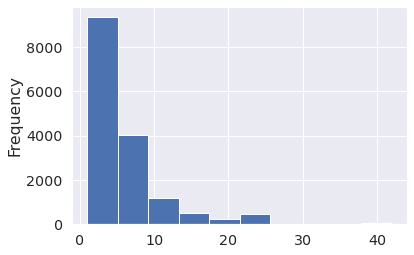

In [ ]:
df['building.floorsCount'].plot.hist();

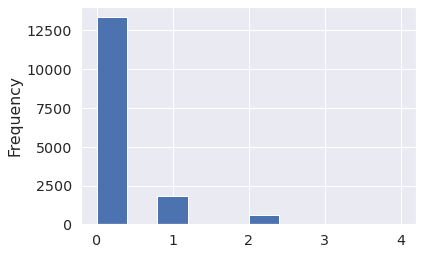

In [ ]:
df['building.floorsCount_dec'] = df['building.floorsCount'].apply(lambda x: x//10)
df['building.floorsCount_dec'].plot.hist();

In [ ]:
all_cat_feats = [
    'conditiontype',
    'status',
    'waterpipescount',
    'inputtype',
    'category',
    'layout',
    'hasshopwindows',
    'islegaladdressprovided',
    'floormaterialtype',
    'placementtype',
    'hasfurniture',
    'accesstype',
    'canparts',
    'isoccupied',
    'building.floorsCount_dec',
    'geo_district.raion',
]

In [ ]:
df[all_cat_feats] = df[all_cat_feats].fillna('N/A')
for feat in all_cat_feats:
    df[feat].replace(True, 'True', inplace=True)
    df[feat].replace(False, 'False', inplace=True)

In [ ]:
df[all_cat_feats].nunique().sort_values(ascending=False)

geo_district.raion          19
conditiontype                7
waterpipescount              6
status                       5
inputtype                    5
layout                       5
building.floorsCount_dec     5
category                     4
hasshopwindows               3
islegaladdressprovided       3
floormaterialtype            3
placementtype                3
hasfurniture                 3
accesstype                   3
canparts                     3
isoccupied                   3
dtype: int64

In [ ]:
for feat in all_cat_feats:
    print(f'{feat:>30}, {df[feat].unique()}')

                 conditiontype, ['typical' 'office' 'N/A' 'finishing' 'cosmeticRepairsRequired'
 'majorRepairsRequired' 'design']
                        status, ['Published' 'Draft' 'Deactivated' 'Deleted' 'Refused']
               waterpipescount, ['N/A' '0,0' '2,0' '1,0' '3,0' '4,0']
                     inputtype, ['separateFromStreet' 'N/A' 'commonFromStreet' 'separateFromYard'
 'commonFromYard']
                      category, ['shoppingAreaRent' 'officeRent' 'officeSale' 'shoppingAreaSale']
                        layout, ['N/A' 'openSpace' 'mixed' 'cabinet' 'corridorplan']
                hasshopwindows, ['True' 'N/A' 'False']
        islegaladdressprovided, ['N/A' 'True' 'False']
             floormaterialtype, ['N/A' 'concrete' 'polymeric']
                 placementtype, ['shoppingMall' 'N/A' 'streetRetail']
                  hasfurniture, ['False' 'N/A' 'True']
                    accesstype, ['N/A' 'free' 'passSystem']
                      canparts, ['False' 'True' 'N/A']

In [ ]:
X = df[all_cat_feats].values
y = df.target.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

enc = OneHotEncoder(drop='first')
X_train = enc.fit_transform(X_train)
X_test = enc.transform(X_test)

forest = RandomForestRegressor(random_state=42).fit(X_train, y_train)

print_metrics(X_train, X_test, y_train, y_test, model=forest)

                   train                  test
R2                 0.571                 0.392
MSE          10707211.44           14208996.49
MAPE               0.203                 0.240


In [ ]:
# X = df[all_cat_feats].values
X_df = pd.get_dummies(df[all_cat_feats])
X = X_df.values
y = df.target.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# enc = OneHotEncoder(drop='first')
# X_train = enc.fit_transform(X_train)
# X_test = enc.transform(X_test)

forest = RandomForestRegressor(random_state=42).fit(X_train, y_train)

print_metrics(X_train, X_test, y_train, y_test, model=forest)

                   train                  test
R2                 0.571                 0.388
MSE          10705449.91           14292485.99
MAPE               0.206                 0.240


Кажется что категориальные фичи волне могут быть полезны. В целом, обьяснено 38% дисперсии на тесте.

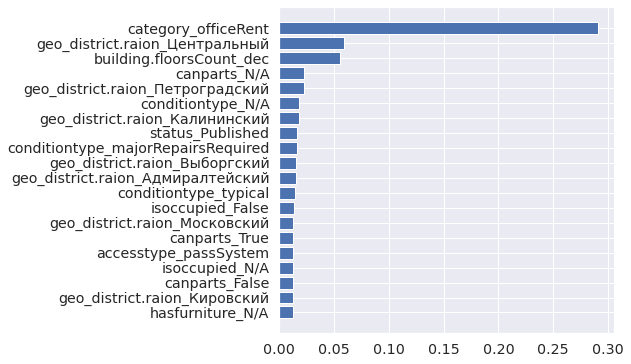

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
df_feature_importances = pd.DataFrame(
    zip(X_df.columns, forest.feature_importances_.squeeze()),
    columns=['feat', 'importance']
)
df_feature_importances.sort_values(by='importance', ascending=True, inplace=True)
df_feature_importances = df_feature_importances.tail(20)
ax.barh(df_feature_importances.feat.values, df_feature_importances.importance.values);

Ещё можно посмотреть насколько в том или ином составе фичи дают схожий по точности результат.

In [ ]:
def calc(feats: List) -> float:
    X = df[feats].values
    y = df.target.values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    enc = OneHotEncoder(drop='first')
    X_train = enc.fit_transform(X_train)
    X_test = enc.transform(X_test)

    forest = RandomForestRegressor(random_state=42).fit(X_train, y_train)
    
    return metrics.r2_score(y_true=y_test, y_pred=forest.predict(X_test))

errors = {}
for f1 in tqdm(all_cat_feats):
    errors[f1] = calc([f1,])
for k, v in sorted(errors.items(), key=itemgetter(1), reverse=True)[:10]:
    print(f'{k}: {v:.3f}')

errors = {}
for f1, f2 in tqdm(list(itertools.combinations(all_cat_feats, 2))):
    errors[f'{f1}, {f2}'] = calc([f1, f2])
for k, v in sorted(errors.items(), key=itemgetter(1), reverse=True)[:10]:
    print(f'{k}: {v:.3f}')

  0%|          | 0/16 [00:00<?, ?it/s]

category: 0.188
conditiontype: 0.106
geo_district.raion: 0.052
accesstype: 0.050
placementtype: 0.042
building.floorsCount_dec: 0.030
hasshopwindows: 0.026
inputtype: 0.020
status: 0.018
layout: 0.006


  0%|          | 0/120 [00:00<?, ?it/s]

category, geo_district.raion: 0.248
category, building.floorsCount_dec: 0.200
category, layout: 0.195
category, canparts: 0.193
category, hasshopwindows: 0.191
waterpipescount, category: 0.191
status, category: 0.190
category, floormaterialtype: 0.190
category, isoccupied: 0.190
category, accesstype: 0.189


Выберем топ-3 фичи из первого списка(обьяснния дисперсии при использовании одной фичи), а так же добавим фичи входящие в топ-3 наборов из двух фичей. 

In [ ]:
top_cat_feats = [
    'category',
    'conditiontype',
    'geo_district.raion',
    'building.floorsCount_dec',
    'layout'
]

X = df[top_cat_feats].values
y = df.target.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

enc = OneHotEncoder(drop='first')
X_train = enc.fit_transform(X_train)
X_test = enc.transform(X_test)

forest = RandomForestRegressor(random_state=42).fit(X_train, y_train)

print_metrics(X_train, X_test, y_train, y_test, model=forest)

                   train                  test
R2                 0.385                 0.318
MSE          15376813.78           15925589.56
MAPE               0.263                 0.265


Итого получилось обьяснить 31.8% дисперсии на тесте. Используя фичи:
- `category` - предназначение помещения (офис, магазин, ..)
- `conditiontype` - состояние ремонта
- `geo_district.raion` - район города
- `building.floorsCount_dec` - кол-во этажей в здании (в десятках)
- `layout` - тип пространства (кабинеты, опенспейс, ..)

# численные + категориальные фичи

In [ ]:
top_cat_feats

['category',
 'conditiontype',
 'geo_district.raion',
 'building.floorsCount_dec',
 'layout']

In [ ]:
top_numeric_feats = numeric_feats

In [ ]:
df[top_numeric_feats + top_cat_feats].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15826 entries, 1 to 22755
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   totalarea                 15826 non-null  float64
 1   floornumber               15826 non-null  int64  
 2   category                  15826 non-null  object 
 3   conditiontype             15826 non-null  object 
 4   geo_district.raion        15826 non-null  object 
 5   building.floorsCount_dec  15826 non-null  int64  
 6   layout                    15826 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 989.1+ KB


In [ ]:
X = pd.get_dummies(df[top_numeric_feats + top_cat_feats]).values
y = df.target.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train = imp.fit_transform(X_train)
X_test = imp.transform(X_test)

forest = RandomForestRegressor(random_state=42).fit(X_train, y_train)

print_metrics(X_train, X_test, y_train, y_test, model=forest)

                   train                  test
R2                 0.938                 0.612
MSE           1560458.46            9061858.73
MAPE               0.079                 0.168


Таким образом удалось обьяснить 61% дисперсии на тесте. Модель ошибается в среднем на 16% на тестовых данных.

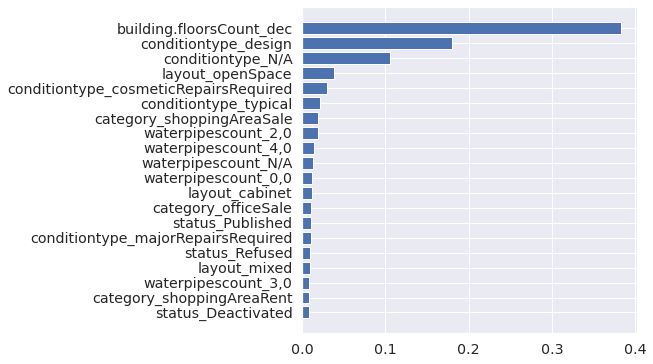

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
df_feature_importances = pd.DataFrame(
    zip(X_df.columns, forest.feature_importances_.squeeze()),
    columns=['feat', 'importance']
)
df_feature_importances.sort_values(by='importance', ascending=True, inplace=True)
df_feature_importances = df_feature_importances.tail(20)
ax.barh(df_feature_importances.feat.values, df_feature_importances.importance.values);

Что ещё можно сделать? (от простого к сложному)
- переписать валидацию на среднюю по K-фолдам
- проверить категориальные фичи связанные с этажом, у нас есть информация о том на каком этаже находится обьект и о том сколько этажей в здании, можно сконструировать фичи вида:
    - находится ли обьект на первом этаже
    - находится ли обьект на последнем этаже
- поработать с координатами обьектов, возможно удастся выделить территориальные кластеры которые играют большую роль в определении цены, например:
    - для Москвы это может быть кластер обьектов расположенных в Moscow-city или в садовом кольце
    - попробовать фичи вида: расстояние от центра города, расстояние от ближайшей станции метро
- подумать о том какая метрика нас вообще интересует? Важно оценить стоимость за кв метр в абсолютных значениях или в относительных (MSE vs MAPE)? Даже если мы говорим о абсолютных значения то вероятно имеет смысл рассмотреть метрику ошибки не самой цены, а логарифма от неё.
- использовать более продвинутые модели бустинга(вроде LightGBM, XGBoost, CatBoost)
- построить ансамбль моделей и конечный результат рассчитывать как среднее от моделей первого уровня или обучить ещё одну модель поверх

# Рассмотрим детальнее сегмент "более 30k"

In [ ]:
df = read_data()
df = add_new_feats(df)

In [ ]:
X = pd.get_dummies(df[df.target > 30000][top_numeric_feats + top_cat_feats]).values
y = df[df.target > 30000].target.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train = imp.fit_transform(X_train)
X_test = imp.transform(X_test)

forest = RandomForestRegressor(random_state=42).fit(X_train, y_train)

print_metrics(X_train, X_test, y_train, y_test, model=forest)

                   train                  test
R2                 0.864                 0.773
MSE     1329483312353.32      2469082945049.22
MAPE               0.364                 0.722


Для сегмента цен более 30 тыс. Модель может обьяснить 77% дисперсии на тесте.

In [ ]:
X = pd.get_dummies(df[top_numeric_feats + top_cat_feats]).values
y = df.target.values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42, stratify=y > 30000
)

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train = imp.fit_transform(X_train)
X_test = imp.transform(X_test)

forest = RandomForestRegressor(random_state=42).fit(X_train, y_train)

print_metrics(X_train, X_test, y_train, y_test, model=forest)

                   train                  test
R2                 0.831                 0.244
MSE      496327914940.38      2434632039694.56
MAPE               0.293                 1.292


Если же строить модель на всём наборе данных, то результаты не столь впечатляющие, только 24% обьяснённой дисперсии на тесте. Отчасти это происходит из-за того что мы заполняем пропуски в данных средним значением и, очевидно, это значение отличается для сегментов "до 30k" и "более 30k".

Конечно же в продакшене у нас не будет информации о ценовом сегменте обьекта, так что его придётся тоже предсказывать по имеющимся фичам. Попробуем написать полный папйплайн проторипа.

In [ ]:
df['segment'] = df.apply(lambda x: False if x['target'] < 30000 else True, axis=1)

In [ ]:
X_df = pd.get_dummies(df[top_numeric_feats + top_cat_feats])
X = X_df.values
y = df.segment.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train = imp.fit_transform(X_train)
X_test = imp.transform(X_test)

forest = RandomForestClassifier(random_state=42).fit(X_train, y_train)

roc_auc_train = metrics.roc_auc_score(
    y_true=y_train, y_score=forest.predict_proba(X_train)[:, 1]
)
roc_auc_test = metrics.roc_auc_score(
    y_true=y_test, 
    y_score=forest.predict_proba(X_test)[:, 1]
)

print(f"      {'train':>12}  {'test':>12}")
print(f'ROCAUC{roc_auc_train:>12.6f}  {roc_auc_test:>12.6f}')

             train          test
ROCAUC    0.999548      0.981824


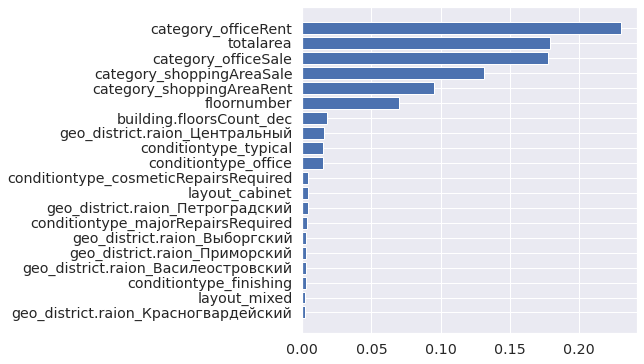

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
df_feature_importances = pd.DataFrame(
    zip(X_df.columns, forest.feature_importances_.squeeze()),
    columns=['feat', 'importance']
)
df_feature_importances.sort_values(by='importance', ascending=True, inplace=True)
df_feature_importances = df_feature_importances.tail(20)
ax.barh(df_feature_importances.feat.values, df_feature_importances.importance.values);

Итак, что у нас есть ?

- модель которая почти идеально (ROCAUC 0.98 на тесте) разделяет обьекты на сегменты "до 30k" и "более 30k"
- модель которая может обьяснить 61% дисперсии на тесте для сегмента "до 30k"
- модель которая может обьяснить 77% дисперсии на тесте для сегмента "более 30k"

# full pipeline

In [ ]:
def run_full_pipline(data: pd.DataFrame, feats: List[str]):
    X = pd.get_dummies(data[feats]).values
    y = data[['target', 'segment']].values
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=42, stratify=y > 30000
    )

    # prepare
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    X_train = imp.fit_transform(X_train)
    X_test = imp.transform(X_test)

    # fit
    rf_for_split_segmants = RandomForestClassifier(random_state=42)\
    .fit(X_train, y_train[:, 1].astype('bool'))

    is_high_train = y_train[:, 1].astype('bool')
    is_high_test = y_test[:, 1].astype('bool')
    rf_for_high_segmant = RandomForestRegressor(random_state=42)\
    .fit(X_train[is_high_train], y_train[is_high_train][:, 0])
    rf_for_low_segmant = RandomForestRegressor(random_state=42)\
    .fit(X_train[~is_high_train], y_train[~is_high_train][:, 0])

    # validate
    is_high_segment = rf_for_split_segmants.predict(X_test)
    y_predict_low = rf_for_low_segmant.predict(X_test[~is_high_segment])
    y_predict_high = rf_for_high_segmant.predict(X_test[is_high_segment])

    y_pred = np.concatenate((y_predict_low, y_predict_high), axis=0)
    y_true = np.concatenate(
        (y_test[~is_high_segment][:, 0], y_test[is_high_segment][:, 0]), axis=0
    )

    print_metrics_raw(y_true, y_pred)

In [ ]:
run_full_pipline(df, feats=top_numeric_feats + top_cat_feats)

                      test
R2                   0.724
MSE        888957015443.75
MAPE                 0.949


Модель может обьяснить 72% дисперсии на тесте. Напомню что если обучать одну модель на всём спектре цен, то она сможет обьяснить лишь 24% дисперсии на тесте (почти втрое меньше).

# Попробуем улучшить показатели

#### Попробуем поэкспериментировать с фичами связанными с этажом обьекта

In [ ]:
df['is_ground_floor'] = df['floornumber'].apply(lambda x: x == 1)
df['is_underground_floor'] = df['floornumber'].apply(lambda x: x < 0)
df['is_last_floor'] = df.apply(
    lambda x: x['floornumber'] == x['building.floorsCount'], axis=1
)

In [ ]:
run_full_pipline(
    data=df,
    feats=top_numeric_feats + top_cat_feats + [
        'is_ground_floor',
        'is_underground_floor',
        'is_last_floor',
    ]
)

                      test
R2                   0.724
MSE        888717812391.19
MAPE                 1.003


Прироста точности не наблюдается.

#### Попробуем поработать с гео данными

Т.к. для сегмента "до 30k" наша модель обьясняет только ~60% дисперсии (против ~75% для сегмента "более 30k") и в этом сегменте расположены 70% обьектов, начнём с него.

In [ ]:
q90 = df['target'].quantile(.90)
df['target_cut'] = df['target'].apply(lambda x: x if x < q90 else q90)
q33, q66 = df[df.target < 30000]['target'].quantile([.33, .66])
df['target_low_sub_segment'] = df[df.target < 30000]['target'].apply(
    lambda x: 1 if x < q33 else 2 if x < q66 else 3
)

Посмотрим на расположение 0-33 квантиля и 66-100 квантиля, что бы отличие классов было существенным.

In [ ]:
fig = px.scatter_mapbox(
    df[(df.target < 30000) & (df.target_low_sub_segment != 2)], 
    lon="geo_coordinates_lng",    
    lat="geo_coordinates_lat",  
    color="target_low_sub_segment", 
    color_continuous_scale='rainbow', # viridis 
    size_max=25, 
    zoom=10
)
fig.show()

Построим это же распределение через matplotlib.

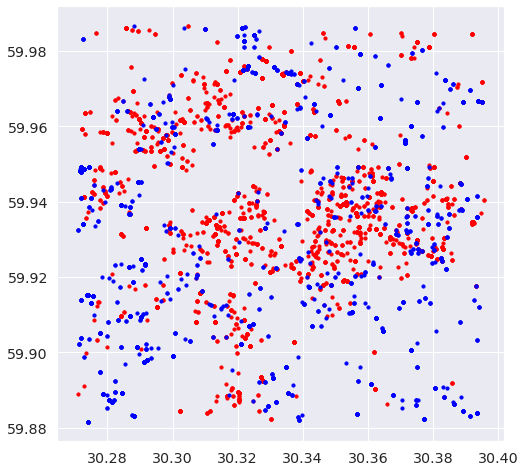

In [ ]:
df_ = df[(df.target < 30000) & (df.target_low_sub_segment != 2)]
lng_q05, lng_q95 = df_['geo_coordinates_lng'].quantile([.15, .85])
lat_q05, lat_q95 = df_['geo_coordinates_lat'].quantile([.15, .85])
df__ = df_[
    (df_['geo_coordinates_lat'] > lat_q05) & (df_['geo_coordinates_lng'] > lng_q05) &
    (df_['geo_coordinates_lat'] < lat_q95) & (df_['geo_coordinates_lng'] < lng_q95)
]
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(
    df__[df__.target_low_sub_segment == 3]['geo_coordinates_lng'].values,
    df__[df__.target_low_sub_segment == 3]['geo_coordinates_lat'].values,
    color='red',
    s=10
)
ax.scatter(
    df__[df__.target_low_sub_segment == 1]['geo_coordinates_lng'].values,
    df__[df__.target_low_sub_segment == 1]['geo_coordinates_lat'].values,
    color='blue',
    s=10
)
plt.show()

###### K-means

In [ ]:
X_high = np.array(list(zip(
    df__[df__.target_low_sub_segment == 3]['geo_coordinates_lng'].values,
    df__[df__.target_low_sub_segment == 3]['geo_coordinates_lat'].values
)))
X_low = np.array(list(zip(
    df__[df__.target_low_sub_segment == 1]['geo_coordinates_lng'].values,
    df__[df__.target_low_sub_segment == 1]['geo_coordinates_lat'].values
)))

Text(0.5, 1.0, 'Elbow curve')

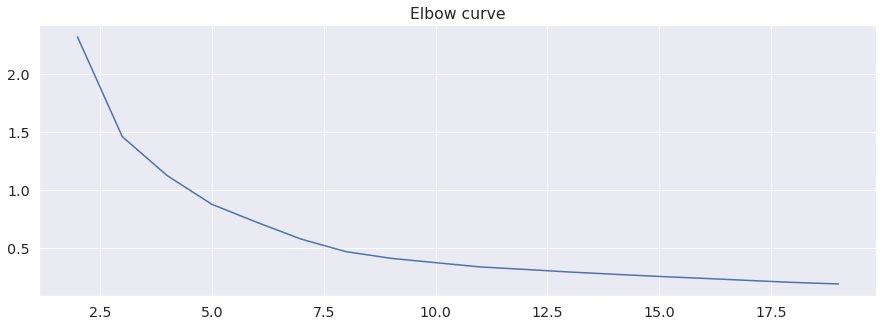

In [ ]:
distorsions = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_high)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions)
plt.grid(True)
plt.title('Elbow curve')

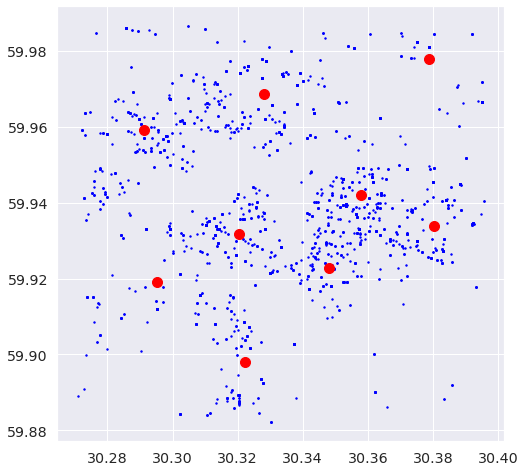

In [ ]:
means = KMeans(n_clusters=9, random_state=0).fit(X_high)

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X_high[:, 0], X_high[:, 1], color='blue', s=2)
ax.scatter(
    means.cluster_centers_[:, 0],
    means.cluster_centers_[:, 1],
    color='red',
    s=100
)
plt.show()

Text(0.5, 1.0, 'Elbow curve')

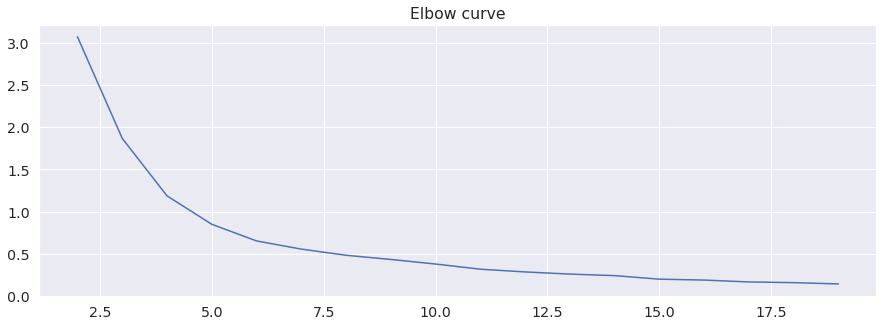

In [ ]:
distorsions = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_low)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions)
plt.grid(True)
plt.title('Elbow curve')

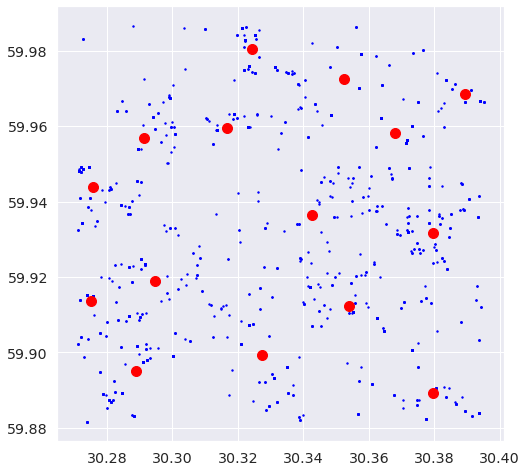

In [ ]:
means = KMeans(n_clusters=15, random_state=0).fit(X_low)

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X_low[:, 0], X_low[:, 1], color='blue', s=2)
ax.scatter(
    means.cluster_centers_[:, 0],
    means.cluster_centers_[:, 1],
    color='red',
    s=100
)
plt.show()

###### DBSCAN

In [ ]:
clustering = DBSCAN(eps=0.008, min_samples=2).fit(X_high)
# clustering.labels_.shape
# fig, ax = plt.subplots(figsize=(8, 8))
# ax.scatter(X[:, 0], X[:, 1], color='blue', s=2)
# plt.show()
clustering.labels_.min(), clustering.labels_.max()

(-1, 12)

-1 91


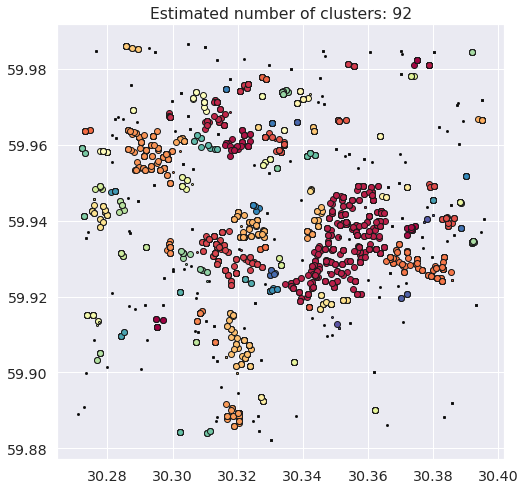

In [ ]:
clustering = DBSCAN(eps=0.0025, min_samples=5).fit(X_high)
print(clustering.labels_.min(), clustering.labels_.max())

core_samples_mask = np.zeros_like(clustering.labels_, dtype=bool)
core_samples_mask[clustering.core_sample_indices_] = True
labels = clustering.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

unique_labels = set(labels)
colors = [
    plt.cm.Spectral(each)
    for each in np.linspace(0, 1, len(unique_labels))
]
fig, ax = plt.subplots(figsize=(8, 8))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X_high[class_member_mask & core_samples_mask]
    ax.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

    xy = X_high[class_member_mask & ~core_samples_mask]
    ax.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=2)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

Мне лично это больше нравится чем результаты по K-means. Конечно может быть что я недостаточно времени уделил подбору гиперпараметров для K-means, и оценка в любом случае носит субьективный характер. Но пока остановися на методе кластеризации DBSCAN.

-1 96


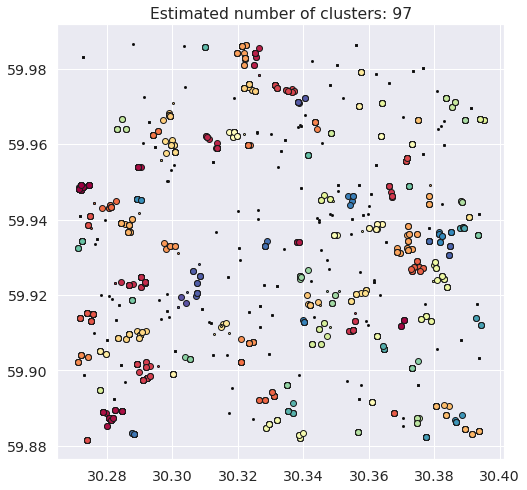

In [ ]:
clustering = DBSCAN(eps=0.003, min_samples=5).fit(X_low)
print(clustering.labels_.min(), clustering.labels_.max())

core_samples_mask = np.zeros_like(clustering.labels_, dtype=bool)
core_samples_mask[clustering.core_sample_indices_] = True
labels = clustering.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

unique_labels = set(labels)
colors = [
    plt.cm.Spectral(each)
    for each in np.linspace(0, 1, len(unique_labels))
]
fig, ax = plt.subplots(figsize=(8, 8))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X_low[class_member_mask & core_samples_mask]
    ax.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

    xy = X_low[class_member_mask & ~core_samples_mask]
    ax.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=2)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

Не очевидно есть ли здесь какая-то структура. Можно развивать эту тему, но позже, если останется время.

###### Рассмотрим верхний ценоновой под-сегмент

-1 91


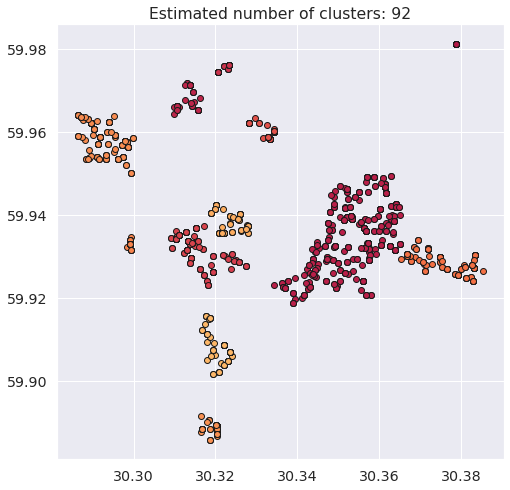

In [ ]:
clustering = DBSCAN(eps=0.0025, min_samples=5).fit(X_high)
print(clustering.labels_.min(), clustering.labels_.max())

core_samples_mask = np.zeros_like(clustering.labels_, dtype=bool)
core_samples_mask[clustering.core_sample_indices_] = True
labels = clustering.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

d = np.array([
    (i, list(labels).count(i))
    for i in set(labels)
    if i > 0 and list(labels).count(i) > 40
])
s = pd.Series(d[:, 1], index=d[:, 0])
s.sort_values(inplace=True, ascending=False)
s.head(30)

coord_obj_high = []

fig, ax = plt.subplots(figsize=(8, 8))
for k, col in zip(unique_labels, colors):
    if k not in s.index:
        continue
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X_high[class_member_mask & core_samples_mask]
    ax.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)
    
    coord_obj_high = coord_obj_high + list((p[0], p[1]) for p in xy)

#     xy = X_high[class_member_mask & ~core_samples_mask]
#     ax.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
#              markeredgecolor='k', markersize=2)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

Попробуем начертить контуры кластеров, и добавить фичу в оригинальный датасет в духе "обьект попадает в один из контуров".

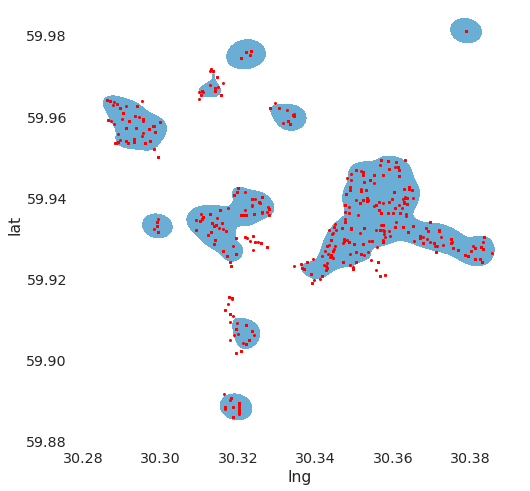

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_facecolor('white')

df_points = pd.DataFrame(coord_obj_high, columns=['lng', 'lat'])
sns.kdeplot(
    data=df_points, x="lng", y="lat", ax=ax, fill=True, bw_method=0.1, cmap="Blues",
    levels=2, thresh=.3,
)

ax.scatter(df_points.lng.values, df_points.lat.values, s=4, color='red');

Такое легко построить с использованием seaborn. Но вот что бы извлечь линнии уровня ..

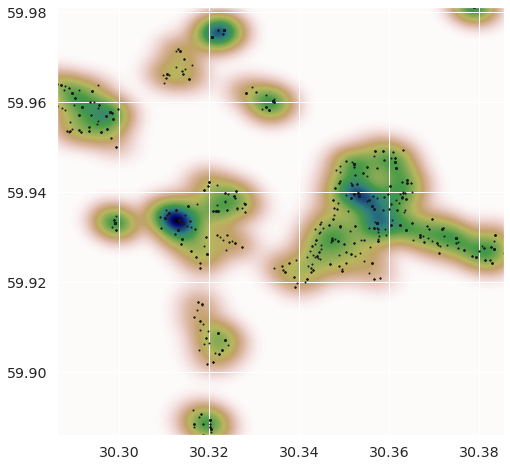

In [ ]:
values = np.vstack([
    df_points.lng.values, 
    df_points.lat.values
])
kernel = stats.gaussian_kde(values, bw_method=0.12)

xmin, xmax = df_points.lng.values.min(), df_points.lng.values.max()
ymin, ymax = df_points.lat.values.min(), df_points.lat.values.max()
X, Y = np.mgrid[xmin:xmax:500j, ymin:ymax:500j]
positions = np.vstack([X.ravel(), Y.ravel()])

Z = np.reshape(kernel(positions).T, X.shape)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r, extent=[xmin, xmax, ymin, ymax])
ax.plot(df_points.lng.values, df_points.lat.values, 'k.', markersize=2)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
plt.show()

Что бы получить доступ к тому что по сути крутится под капотом у `sns.kdeplot` приходится проделывать долгий путь через `stats.gaussian_kde`.

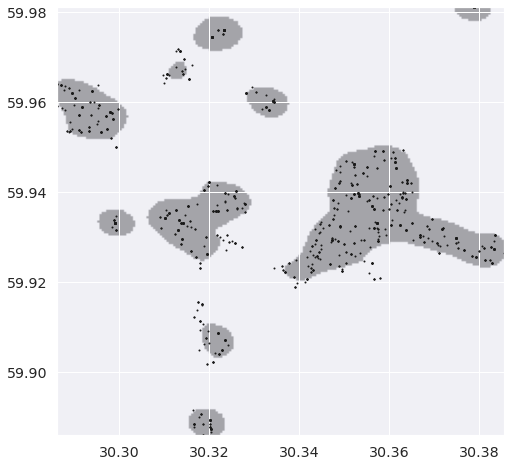

In [ ]:
values = np.vstack([
    df_points.lng.values, 
    df_points.lat.values
])
kernel = stats.gaussian_kde(values, bw_method=0.12)

xmin, xmax = df_points.lng.values.min(), df_points.lng.values.max()
ymin, ymax = df_points.lat.values.min(), df_points.lat.values.max()
X, Y = np.mgrid[xmin:xmax:200j, ymin:ymax:200j]
positions = np.vstack([X.ravel(), Y.ravel()])

Z = np.reshape(kernel(positions).T, X.shape)
Z = np.vectorize(lambda x: 0 if x > 300 else 1)(Z)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(np.rot90(Z), cmap='gray', extent=[xmin, xmax, ymin, ymax], alpha=0.3)
ax.plot(df_points.lng.values, df_points.lat.values, 'k.', markersize=2)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
plt.show()

То же самое упражнение, но результат бинарный, с отсечением по пороговому значению.

In [ ]:
fig = px.density_mapbox(
    df_points, 
    lat="lat", 
    lon="lng",     
    radius=8, 
    zoom=10
)
fig.show()

Строго говоря, надо что бы при формировании этих контуров не использовались данные из теста. Т.е. формировать их только по данным из трейна.

In [ ]:
all_points = []
for i in range(X.shape[0]):
    for j in range(Y.shape[0]):
        if Z[i, j] == 0:
            continue
        lng = X[i, j]
        lat = Y[i, j]
        val = Z[i, j]
        all_points.append(
            (lng, lat, val)
        )
df_all_points = pd.DataFrame(all_points, columns=['lng', 'lat', 'value'])
step = max(abs(X[0, 0] - X[1, 0]), abs(Y[0, 0] - Y[0, 1]))

In [ ]:
points = np.vstack([df_all_points.lng.values, df_all_points.lat.values]).T
df['good_position'] = df.apply(
    lambda x: 
        np.linalg.norm(
            points - (x['geo_coordinates_lng'], x['geo_coordinates_lat']), 
            axis=1
        ).min() < step, 
    axis=1
)

In [ ]:
df[df.target < 30000].groupby('good_position')['good_position'].count()

good_position
False    11879
True      3947
Name: good_position, dtype: int64

In [ ]:
df[df.target > 30000].groupby('good_position')['good_position'].count()

good_position
False    4751
True     2038
Name: good_position, dtype: int64

Несмотря на то что мы строили эту фичу по данным сегмента "до 30k", можно видеть что в сегменту "более 30k" в процентном отношении даже больше обьектов 42.8% (против 33.2% для сегмента "до 30k") подошло под критерии фичи.

In [ ]:
run_full_pipline(data=df, feats=top_numeric_feats + top_cat_feats)

                      test
R2                   0.724
MSE        888957015443.75
MAPE                 0.949


Было.

In [ ]:
run_full_pipline(
    data=df,
    feats=top_numeric_feats + top_cat_feats + ['good_position']
)

                      test
R2                   0.855
MSE        465889243556.25
MAPE                 0.336


In [ ]:
top_numeric_feats

['totalarea', 'floornumber']

Стало.

Ура! Все упражнения с кластеризаций и линиями уровня по KDE были не зря!

Таким образом удалось обьяснить 85% (R2) дисперсии на тесте. Модель ошибается в среднем на 33% (MAPE) на тестовых данных (против 94% до использования этой фичи).

In [ ]:
city_center = np.array((59.9311, 30.3609))
df['dist_from_city_center'] = df.apply(
    lambda x: 
        np.linalg.norm(city_center - (x['geo_coordinates_lng'], x['geo_coordinates_lat'])), 
    axis=1
)

run_full_pipline(
    data=df,
    feats=top_numeric_feats + top_cat_feats + ['good_position', 'dist_from_city_center']
)

                      test
R2                   0.842
MSE        507888547027.31
MAPE                 0.306


Расстояние от центра города не даёт значительного выигрыша в точности, R2 снизился на 1.3%(плохо), MAPE снизился на 3%(хорошо).

Next steps.

- починить определение фичи `good_position`
- улучшение валидации модели (K-fold)
- фича инженеринг
- продвинутые модели бустинга (LightGBM, XGBoost, CatBoost)
- утвердить метрику качества молели
- тюнинг гиперпараметров
- ансамбль моделей

###### починить определение фичи
Сейчас определени фичи good_position сделно не корректно, т.к. при определении контуров используются тестовые данные.

######  улучшение валидации модели
Нужно применить K-fold валидацию для повышения точности оценок качества модели.

###### фича инженеринг
- пройтись ещё раз по фичам представленным в файле, может я что-то упустил
- проверить фичу "расстояние от ближайшей станции метро"
- пообщаться с доменным экспертом о фундаментальных причинах влияющих на таргет

######  продвинутые модели бустинга
Сейчас используется `sklearn.ensemble.RandomForestRegressor`, но кажется можно будет получить увеличение точности просто применив какую-либо из библиотек бустинга случайного леса: LightGBM, XGBoost, CatBoost. Реализация врятли займёт много времени, но есть надежда что это сразу даст небольшую прибавку в качестве предсказаний.

###### утвердить метрику качества молели
Подумать о том какая метрика нас вообще интересует? Важно оценить стоимость за кв. метр в абсолютных значениях или в относительных (MSE vs MAPE)? Даже если мы говорим о абсолютных значения то вероятно имеет смысл рассмотреть метрику ошибки не самой цены, а логарифма от неё. Т.к. я предлагаю рассматривать ценовые сегменты отдельно (до 30k и после) то возможно имело бы смысл: 
- для нижнего ценового сегмента, где цены не так велики остановиться на MSE, т.к. хочется поточнее определи цену и даже небольшие отклонения могут быть неприятными для бизнес-использования результатов модели
- для верхнего ценового сегмента, где цены довольно велики остановиться на MAPE, т.к. хочется скорее не допустить ошибки "в разы", потому что говорить о точном попадании в таргет слишком сложно

######  тюнинг гиперпараметров
Кажется важным **до** начала тюнинга определиться с метрикой качества(см. предыдущий п.) что бы в будущем не пришлось переделывать.
- тюнинг гиперпараметров леса
- тюнинг гиперпараметров определения фичей (например для фичи `good_position` это параметры кластеризации DBSCAN, и параметры KDE для определения линий уровня)
- можно попробовать что-то классическое(GridSearchCV, RandomizedSearchCV) или применить оптимизацию целевой функции, например с помощью [Optuna](https://github.com/optuna/optuna)

######  ансамбль моделей
Построить ансамбль моделей и конечный результат рассчитывать как среднее от моделей первого уровня или обучить ещё одну модель поверх.